# Reductio Ad Absurdum - A Judicial Simulation

> "Reductio ad absurdum... is a form of argument that attempts to either disprove a statement by showing it inevitably leads to a ridiculous, absurd, or impractical conclusion, or to prove one by showing that if it were not true, the result would be absurd or impossible." - Wikipedia.

The **qnarre** narrative analyzing software operates on flat text statements represented by lists of sentences. The input **evidence** of a qnarre session is the list of all statements to be considered.

These statements are further grouped into an ordered list of **docs** of pages and paragraphs. The docs are persisted in varied formats in a hierarchical and rooted directory structure.

When a statement is assigned a **credibility** in qnarre, it becomes a **claim**. Credibility is an ordering of all claims defined to intuitively reflect that, for example, a police report or an allegation made during a trial in Court can be trusted more than a casual verbal opinion overheard on the street. 

All docs in qnarre belong to a **genre** (e.g. letter, motion, affidavit, judgment, etc.) that implicitly weighs all contained claims of the doc with an inherent, default credibility.

Claims can also be assigned incidental **weights** that fine-tune their individual credibilities. To model a doc of a specific genre, and containing 100 random claims, we can run the Python code presented below.

Before any of our simulations can be tried, or repeated with changed parameters, our environment needs to be initialized:

In [1]:
import numpy as np
import numpy.random as r
import matplotlib.pyplot as plt

%matplotlib inline

# Also, let's create 5 genres represented as their credibilities
genres = (2, 3, 5, 6, 9)

We define a function to conveniently create a new doc:

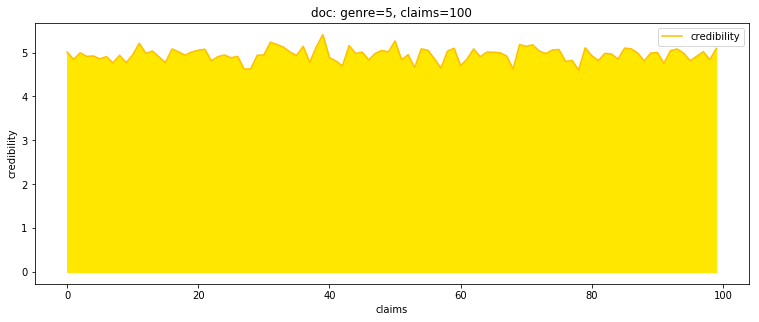

In [2]:
def new_doc(depth):
    genre = genres[r.randint(len(genres))] # random genre from our list
    sigma = r.sample() # standard deviation from a uniform distribution
    claims = r.normal(genre, sigma, depth) # and the list of claims
    return genre, np.absolute(claims)

genre, claims = new_doc(depth=100) # create a doc with 100 claims

# Let's plot this, the chart will be randomly different with every run 
_, ax = plt.subplots(figsize=(12.8, 4.8))

ax.set_title('doc: genre={}, claims={}'.format(genre, len(claims)))
ax.set_xlabel('claims')
ax.set_ylabel('credibility')

yellow_l = '#ffe700'
yellow_d = '#ffbe00'

x = np.arange(len(claims))
y = claims
ax.plot(x, y, color=yellow_d, label='credibility')
ax.fill_between(x, y, color=yellow_l)
ax.legend()

plt.show()

The code above, and below, relies on randomly synthesizing varied data, or "sampling" from already created lists of values. These processes are defined in terms of their parameters.

All our simulations are thus driven by our input parameters and/or weights. Parameters and weights are real numbers, or Python `floats`. Some are from the interval [0,1] and can thus be directly used as `prior` probabilities.

Such parameters are:
- the number of docs in an input evidence is reflected by its **breadth**
- the number of claims in any specific doc is influenced by its **depth**.

To model an evidence of random docs with those parameters, we can run:

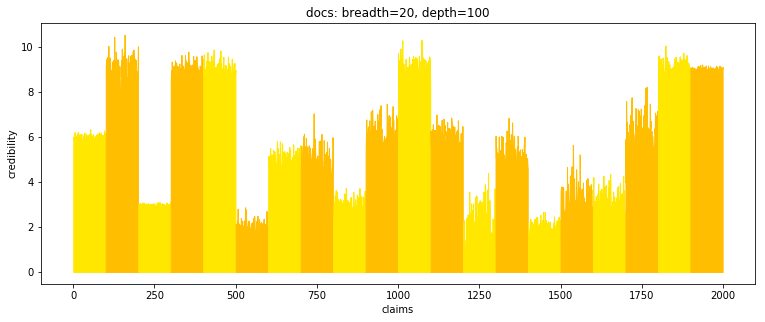

In [3]:
def new_docs(breadth, depth):
    docs, claims = [], []
    for _ in range(breadth): # create each doc of credibilities
        _, cs = new_doc(depth)
        docs.append(cs)
        claims.extend(cs)
    return docs, np.array(claims), breadth, depth

docs, claims, breadth, depth = new_docs(breadth=20, depth=100)

# Let's plot this
_, ax = plt.subplots(figsize=(12.8, 4.8))

ax.set_title('docs: breadth={}, depth={}'.format(breadth, depth))
ax.set_xlabel('claims')
ax.set_ylabel('credibility')

light, dark = yellow_l, yellow_d
offset, color = 0, dark
for d in docs:
    x = np.arange(len(d))
    color = light if color is dark else dark
    ax.fill_between(x + offset, d, color=color)
    offset += len(d)
    
plt.show()

The chosen simple probability distributions for the samples are noted through the choice of functions used. Numpy documentation provides further details.

More sophisticated, `generic` and even `conjugate` probability distributions can be easily plugged in to properly reflect inherent covariance and contravariance present in the data.

The credibility of a claim can be further enhanced by citing an `authority`. Such authority "witnessing" a claim will turn the claim into a **proof**. The `weight` of a proof derived from the authority is the enhancing factor of the underlying claim.

The percentage of proofs in an evidence is its **proven** parameter. To model an evidence witnessed, and thus proven, by authorities, we can run:

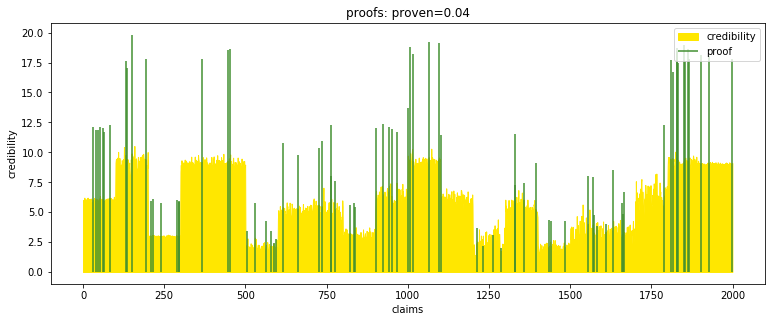

In [4]:
import math

def new_proofs(proven, weight=2):
    nc = len(claims)
    np = math.floor(nc * proven)
    pis = sorted(r.choice(nc, (np, ), replace=False))
    return [(i, max(claims[i], 1) * weight) for i in pis], proven

proofs, proven = new_proofs(proven=0.04)

# Let's plot this
_, ax = plt.subplots(figsize=(12.8, 4.8))

ax.set_title('proofs: proven={}'.format(proven))
ax.set_xlabel('claims')
ax.set_ylabel('credibility')

green = '#408e2f'

x = np.arange(len(claims))
y = claims
ax.fill_between(x, y, color=yellow_l, label='credibility')
x, y = zip(*proofs)
ax.vlines(x, 0, y, color=green, label='proof')
ax.legend()

plt.show()

Claims can be further categorized through `topics`. Grouping together varying topical claims and related proofs improves the understanding of the overall context in an evidence.

**Realities** are such contextual claims encapsulating the inherent, or readily and verifiably inferenceable, "common sense" credibilities.

The percentage of realities of all claims in an evidence is generated from its **contextual** parameter.

A reality, through the thus logically concluded credibility measure called its **coherence**, adds to the overall **certainty** of a simulation. We represent this `certainty` with a natural value of `1.0` and as an obvious upper bound of our charts and simulated "worlds".

Assuming that normal and balanced **ambiguity** rules before an evidence is ever considered, we can model how the realities of an evidence drive the overall understanding from `ambiguity` to `certainty` as follows.

Note that `ambiguity` has become our starting point, the "origin" and baseline with a natural value of `0.0` across the charts:

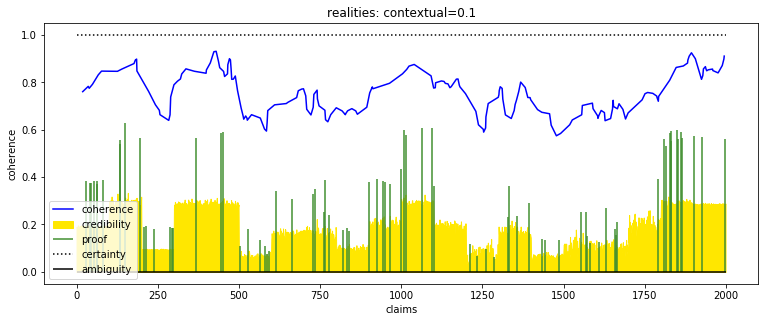

In [5]:
from scipy.ndimage.filters import gaussian_filter1d

def new_reality(claims, proofs, contextual):
    lc = math.ceil(len(claims) * contextual / 10)
    c = np.sum(r.choice(claims, (lc,)))
    lp = math.ceil(len(proofs) * contextual)
    return (c + np.sum(r.choice(proofs, (lp,)))) * contextual

def new_realities(contextual):
    cis = set(range(len(claims)))
    pis, ps = zip(*proofs)
    cis = cis.difference(pis)
    lr = math.floor(len(cis) * contextual)
    ris = sorted(r.choice(list(cis), (lr,), replace=False))
    cis = cis.difference(ris)
    cs = claims[sorted(cis)]
    rs = [claims[i] + new_reality(cs, ps, contextual) for i in ris]
    rs = np.array(rs)
    rmax = np.max(rs)
    rs *= (1 + contextual / 10)
    rs /= rmax 
    return [(j, rs[i]) for i, j in enumerate(ris)], rmax, contextual

realities, rmax, contextual = new_realities(contextual=0.1)

# Let's plot this
_, ax = plt.subplots(figsize=(12.8, 4.8))

ax.set_title('realities: contextual={}'.format(contextual))
ax.set_xlabel('claims')
ax.set_ylabel('coherence')

blue = 'blue'

x = np.arange(len(claims))
cmax = np.max(claims) * 3
y = claims / cmax
ax.fill_between(x, y, color=yellow_l, label='credibility')
x, y = zip(*proofs)
ax.vlines(x, 0, y / cmax, color=green, label='proof')
x, y = zip(*realities)
y = gaussian_filter1d(y, sigma=10 * contextual)
ax.plot(x, y, color=blue, label='coherence')
# And now our bounds for the world of trials:
ax.hlines(1, 0, len(claims), linestyles='dotted', label='certainty')
ax.hlines(0, 0, len(claims), label='ambiguity')
ax.legend()

plt.show()

"*Conflict is opportunity*": good attorneys find intrinsic contradictions and conflicts in lawsuits and creatively expose the consequences, thus elevating or plausibly projecting neutral `ambiguity` to `certainty`. Judgments are then reproducibly made without further consequences and attorneys reap the rewards.

Without such conflicts, or the ability to find them, attorneys starve. Less capable yet "ambitious" or `malicious` attorneys professionally (i.e. "credibly") create, or plainly `fabricate`, artificial conflicts.

Such artificial **conflicts** are thus the fabricated claims that knowingly and purposefully hook into and then graft onto specific perceived realities of an evidence.

The objective of a \[fabricated\] `conflict` is to sow fear, uncertainty and doubt. A conflict, through its intended "credibility", defined hereon as its **fragmentation** measure, adds to the overall **absurdity**, or the level of confusion in the evidence and all its simulations.

So called "high-conflict" attorneys and professionals keenly understand the lucrative potential in this ruthless scheme and advertise their services as "aggressive", simply meaning maliciously `predatorial`, as shown in these simulations.

A conflict's `fragmentation` is thus expressed by, and is proportional to:

- its inherent `weight` measure (e.g. the modelled types of deception, fraud, extortion, etc.)
- the strength, the `coherence`, of its targeted reality (the more absurd something is the more confusion it creates when forcibly taken seriously).

Furthermore, just as a reality is enhanced by numerically more topical yet still semantically broad claims, a conflict is also emphasized by necessarily focused and narrow, almost literal, **repeats** along the famously quoted lines of the ruthless monster:  

> Repeat a lie often enough and it becomes the truth” - Nazi Joseph Goebbels

The percentage of conflicts of all claims in an evidence is generated from its malicious or **malignant** characteristic/parameter. We can model how the conflicts of an evidence fragment the overall reality of a simulation from `ambiguity` to `absurdity` as follows:

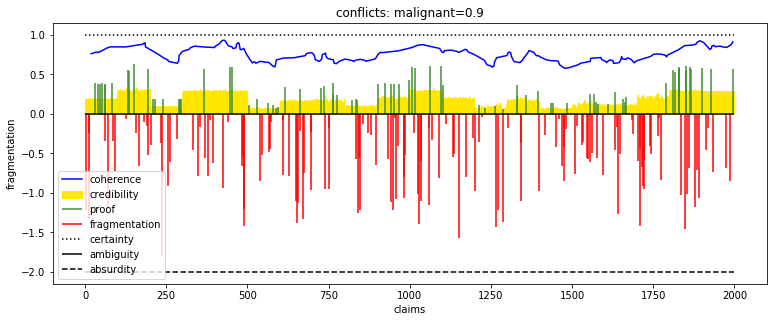

In [6]:
def new_conflict(claims, realities, malignant):
    lc = len(claims) * malignant
    lc = math.floor(lc * r.sample())
    c = np.sum(r.choice(claims, (lc % 13,))) * malignant
    return c * r.choice(realities)

def new_conflicts(malignant):
    cis = set(range(len(claims)))
    pis, _ = zip(*proofs)
    cis = cis.difference(pis)
    ris, rs = zip(*realities)
    cis = cis.difference(ris)
    lf = math.floor(len(cis) * malignant / 10)
    fis = sorted(r.choice(list(cis), (lf,), replace=False))
    cis = cis.difference(fis)
    cs = claims[sorted(cis)]
    fs = [new_conflict(cs, rs, malignant) for i in fis]
    fs = np.array(fs)
    fs /= np.max(fs)
    return [(j, -1.8 * fs[i]) for i, j in enumerate(fis)], malignant

conflicts, malignant = new_conflicts(malignant=0.9)

# Let's plot this
_, ax = plt.subplots(figsize=(12.8, 4.8))

ax.set_title('conflicts: malignant={}'.format(malignant))
ax.set_xlabel('claims')
ax.set_ylabel('fragmentation')

red = 'red'

x = np.arange(len(claims))
cmax = np.max(claims) * 3
y = claims / cmax
ax.fill_between(x, y, color=yellow_l, label='credibility')
x, y = zip(*proofs)
ax.vlines(x, 0, y / cmax, color=green, label='proof')
x, y = zip(*realities)
y = gaussian_filter1d(y, sigma=10 * contextual)
ax.plot(x, y, color=blue, label='coherence')
x, y = zip(*conflicts)
ax.vlines(x, 0, y, color=red, label='fragmentation')
ax.hlines(1, 0, len(claims), linestyles='dotted', label='certainty')
ax.hlines(0, 0, len(claims), label='ambiguity')
ax.hlines(-2, 0, len(claims), linestyles='dashed', label='absurdity')
ax.legend()

plt.show()

Note that `absurdity` is now our lower bound in our charts, and simulations, and it is assigned an artificial value of `-2.0`. The value was chosen to reflect the significant antisymmetry between the necessarily coherent reality and the realm of widly fragmented, confused and outright dellusional "dreams have no limits" absurdity.

As opportunities dwindle in the realm of reality, creatively unbounded,  yet also morally unrestricted, select skilled professionals aim to "legally" profit from the unchartered, and truly vast, "Wild West" of absurdity.

**These simulations and software directly target such professionals, with the stated objective of systematically and sustainably profiting from their current and especially their past exploiting escapades into the "Land of Absurdity".**

Now that some of the used concepts have been defined, we can plot our target domain and its bounds as follows:

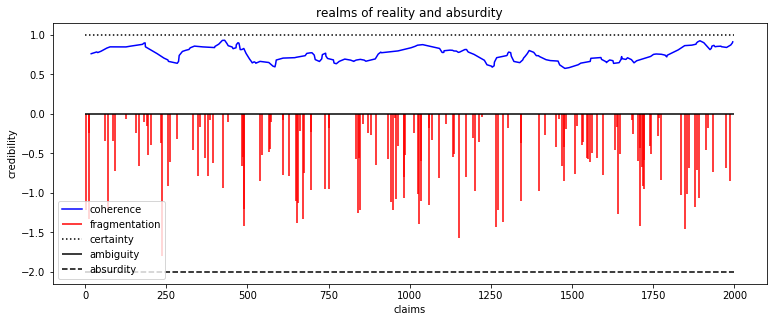

In [7]:
# Let's plot this
_, ax = plt.subplots(figsize=(12.8, 4.8))

ax.set_title('realms of reality and absurdity')
ax.set_xlabel('claims')
ax.set_ylabel('credibility')

x, y = zip(*realities)
y = gaussian_filter1d(y, sigma=10 * contextual)
ax.plot(x, y, color=blue, label='coherence')
x, y = zip(*conflicts)
ax.vlines(x, 0, y, color=red, label='fragmentation')
ax.hlines(1, 0, len(claims), linestyles='dotted', label='certainty')
ax.hlines(0, 0, len(claims), label='ambiguity')
ax.hlines(-2, 0, len(claims), linestyles='dashed', label='absurdity')
ax.legend()

plt.show()

**Judgments** are claims meant to forcefully solve conflicts. If the conflicts are inherent, or simply tractable, judgments restore and reinforce reality thus leading to an obviously sustainable, clear and fair `certainty`.

In a biased, or `prejudiced` simulation, reflected by the evidence's **prejudiced** parameter, the selected conflicts a judgement builds on greatly influence the credibility and thus the soundness of its own conjecture claim.

Judgments that are not sound (i.e. not coherent with reality) cause confusion and possibly destabilizing, long-term upheaval. A judgment's **turmoil** measure is thus expressed by, and is proportional to:

- its inherent `weight` measure (e.g. the modelled types of confusion, bias, fabrication, etc.)
- the actual influence, the sum of the `fragmentations` of all its referenced conflicts (inherent, tractable conflicts are not modelled as they are factored into the coherence of realities).

The percentage of judgments of all claims in an evidence is generated from its `breadth` characteristic/parameter. The `weights` of the judgments are proportional to the `prejudice` parameter of the evidence.

We can model how the judgments of an evidence cause consequential `turmoil` and drive a simulation from `ambiguity` to `absurdity` through confusion as follows:

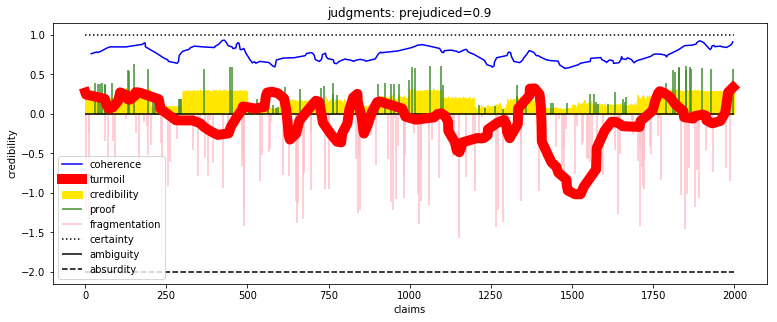

In [9]:
def new_judgment(claims, conflicts, prejudiced):
    lc = len(claims) * prejudiced
    lc = math.floor(lc * r.sample())
    c = np.sum(r.choice(conflicts, (lc % 13,))) * prejudiced
    return abs(c)

def new_judgments(prejudiced):
    cis = set(range(len(claims)))
    pis, _ = zip(*proofs)
    cis = cis.difference(pis)
    ris, _ = zip(*realities)
    cis = cis.difference(ris)
    fis, fs = zip(*conflicts)
    cis = cis.difference(fis)
    lj = math.floor(len(cis) * prejudiced / 10)
    jis = sorted(r.choice(list(cis), (lj,), replace=False))
    cis = cis.difference(jis)
    cs = claims[sorted(cis)]
    js = [abs(new_judgment(cs, fs, prejudiced)) for i in jis]
    js = np.array(js)
    js /= np.max(js)
    js *= np.absolute(r.normal(scale=prejudiced, size=(len(js))))
    return [(j, 0.75 - 3 * js[i]) for i, j in enumerate(jis)], prejudiced

judgments, prejudiced = new_judgments(prejudiced=0.9)

# Let's plot this
_, ax = plt.subplots(figsize=(12.8, 4.8))

ax.set_title('judgments: prejudiced={}'.format(prejudiced))
ax.set_xlabel('claims')
ax.set_ylabel('credibility')

x = np.arange(len(claims))
cmax = np.max(claims) * 3
y = claims / cmax
ax.fill_between(x, y, color=yellow_l, label='credibility')
x, y = zip(*proofs)
ax.vlines(x, 0, y / cmax, color=green, label='proof')
x, y = zip(*realities)
y = gaussian_filter1d(y, sigma=10 * contextual)
ax.plot(x, y, color=blue, label='coherence')
x, y = zip(*conflicts)
ax.vlines(x, 0, y, color='pink', label='fragmentation')
x, y = zip(*judgments)
y = gaussian_filter1d(y, sigma=2)
ax.plot(x, y, color='red', linewidth=10, label='turmoil')
ax.hlines(1, 0, len(claims), linestyles='dotted', label='certainty')
ax.hlines(0, 0, len(claims), label='ambiguity')
ax.hlines(-2, 0, len(claims), linestyles='dashed', label='absurdity')
ax.legend()

plt.show()

This concludes our blog. For more on modeling these concepts in detail, please click on our next blog.